# Rate-distortion theory for minimum information given an average growth rate.

In [1]:
# Our numerical workhorses
import numpy as np
import scipy.optimize
import scipy.special
import scipy.integrate

# Import libraries to parallelize processes
from joblib import Parallel, delayed

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

# Seaborn, useful for graphics
import seaborn as sns

# Import the project utils
import sys
sys.path.insert(0, '../../')
import infofit_utils as utils

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

figdir = '../../fig/blahut_algorithm_rate_distortion/'
tmpdir = '../../tmp/'

In [2]:
# Set PBoC plotting format
utils.viz.set_plotting_style()

## $\LaTeX$ macros
$\newcommand{\ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{\bb}[1]{\mathbf{#1}}$

# Rate distortion theory and the minimum amount of information to sustain an average growth rate

For an ensemble of environments $c$ with probability distribution $P(c)$, we have that the average fitness (growth rate) over the ensemble $\ee{r}$ given an input-output function $P(p \mid c)$ is given by (for continuous case)
\begin{equation}
    \langle r \rangle = \int dC P(c) \int dp P(p \mid c) r(p, c),
\end{equation}
where $r(p, c)$ is the fitness lanscape function that takes as input the protein expression level $p$ and the environmental state (i.e. concentration of relevant chemical $c$). It is easy to see that not all distributions $P(p \mid C)$ are consistent with a given $\langle r \rangle$. Depending on the environment state distribution $P(c)$ different input output functions will have different mean fitness values.

An interesting question then is if there is a minimum value of the mutual information between input and output $I(c; p)$ consistent with a value of $\ee{r}$. This question can be mathematically expressed as a constrained optimization problem that happens to be extremely similar to E.T. Jaynes derivation of the Boltzmann distribution, showing again the unity and power of concepts and models in physics.

As shown in Jaynes classic 1957 paper, the Boltzmann distribution is the distribution that maximizes the Shannon information entropy constrained by an average energy $\ee{E}$. This can be written as an unconstrained minimization problem where we define a Lagrangian of the form
\begin{equation}
    \mathcal{L} = -\sum_i p_i \ln p_i - \lambda \left( \sum_i i p_i - \langle E \rangle \right) - \mu \left( \sum_i p_i - 1 \right),
\end{equation}

where $\lambda$ and $\mu$ are Lagrange multipliers. It is from this minimization problem that we obtain the Boltzmann distribution.

Analogous to this statistical mechanics insight, we can derive the distribution $P(p \mid c)$ that **minimizes** the amount of information constrained by an average growth rate. In this case we have a variational problem in which we try to minimize the mutual information in the space of *all possible distributions* $P(p \mid c)$. This is expressed as
\begin{equation}
     \mathcal{F} \left[ P(p \mid c) \right] \equiv I(c; p) 
     - \lambda \ee{r} 
     - \int dc \mu (c) \int dp P(p \mid c),
\end{equation}
where the second Lagrange multiplier $\mu$ imposes the normalization constraint on $P(p \mid c)$.

It can be shown that the distribution $P(p \mid c)$ that satisfies these conditions is given by

\begin{equation}
    P(p \mid c) = {1 \over \mathcal{Z}(c)} P(p) e^{\beta r(c, p)},
\end{equation}

where $\beta \equiv \lambda \ln 2$, and $\mathcal{Z}(c) = \exp \left[ \ln 2 \mu (c) / P(c) \right]$ is the normalization factor (analogous to the partition function). This "partition function" must therefore satisfy

\begin{equation}
    \mathcal{Z}(c) = \int dp P(p) \exp \left[ \beta r(c, p) \right].
\end{equation}

And since $P(p)$ is obtained by marginalizing $P(p \mid c)$ this can be written as

\begin{equation}
    \mathcal{Z}(c) = \int dp \left( \int dc P(p \mid c)P(c) \right) \exp \left[ \beta r(c, p) \right].
\end{equation}

## Blahut-Arimoto algorithm

This result bring us to our main problem for this notebook. Obtaining the actual distribution $P(p \mid c)$ requires us to implement an elegant algorithm known as the *Blahut algorithm* for rate distortion theory.

The way we will implement the algorithm is by discretizing our otherwise continuous distributions. This means that we will assume that instead of having a continuous probability distribution $P(p)$, we will substitute it with $\bb{q}_p$, a vector that contains all the discrete entries of the distribution. The same applies to the distribution environmental states $P(c) \approx \bb{p}_c$.

For the case of our conditional distribution $P(p \mid c)$ we will approximate it by a transition matrix $\bb{Q}$ such that each entry of the matrix $Q_{p \mid c}$ contains the discrete conditional input-output probability.

The Blahut algorithm takes a proposed initial distribution $\mathbf{q}_p^0$ and through a series of iterative applications of simple operations converges to a distribution $\mathbf{q}_p^k$ and a transition matrix $\mathbf{Q}^k$ such that
\begin{equation}
    I(\bb{p}_c, \bb{Q}^k) \rightarrow R(\ee{r}) \; 
    \text{as}\; k \rightarrow \infty
\end{equation}
where $I(\mathbf{p}_c, \bb{Q})$ is the mutual information given an input probability $\mathbf{p}_c$ and an input-output transition matrix $\mathbf{Q}$, and $R(\ee{r})$ is the so-called **rate-distortion function**.

The definition of this rate-distortion function is exactly what we stated above verbally, i.e. the minimum amount of information consistent with an average growth rate $\langle r \rangle$.

Having worked out the math behind the algorithm myself is time to implement it!

In [130]:
def rate_dist(c, p_rel, beta, Pc, fitness_fun, param,
              fitness_scale=1, epsilon=1E-3):
    '''
    Performs the Blahut algorithm to compute the rate-distortion 
    function R(<r>) given an input C and an output m.
    The average growth rate should be given as the
    RELATIVE DIFFERENCE WITH RESPECT TO THE OPTIMAL growth rate.
    
    Parameters
    ----------
    c : array-like.
        concentration discretized values that are used to compute the
        distributions. logC is assumed to be uniform over the log of the
        values given in the array.
    p_rel : array-like.
        relative expression level with repspect to wild-type.
    beta : float. [-inf, 0]
        slope of the line with constant I(Q) - beta * sD. This parameter emerges
        during the unconstraint optimization as a Lagrange multiplier. It plays
        the analogous role of the inverse temperature in the Boltzmann
        distribution.
    Pc : array-like.
        array containing the probability distribution of each of the
        elements of c.
    fitness_fun : function.
        function to determine the growth rate given an expression level mRNA
        and a substrate concentration C.
    param : dictionary:
        dictionary containing all the parameters for the fitness function.
    fitness_scale : float.
        An optional scaling parameter for the cost function. 
        If set, the cost used in the algorithm is 
        fitness_scale * fitness_fun(c, p). 
        This can be useful for avoiding numerical overflow or underflow 
        for badly scaled cost functions.
    epsilon : float.
        error tolerance for the algorithm to stop the iterations. The smaller
        epsilon is the more precise the rate-distortion function is, but also
        the larger the number of iterations the algorithm must perform
    
    Returns
    -------
    q_m : len(m) array.
        marginal gene expression probability distribution.
    Q_m|C : len(C) x len(m) matrix.
        The input-output transition matrix for each of the inputs and outputs
        given in C and m respectively.
    r : float.
        Average growth rate.
    R(D) : float.
        minimum amount of mutal information I(c;p) consistent with growth rate.
    '''
    # Let's make a 2D grid with the input and output values
    CC, pp = np.meshgrid(C, p_rel)
    
    # Initialize the proposed distribution as a uniform distribution
    # over the values of p_rel
    qp0 = np.repeat(1 / len(p_rel), len(p_rel))
    
    # This will be the probabilities that will be updated on each cycle
    qp = qp0
    
    # Compute the cost matrix
    rhoCm = fitness_fun(CC, pp, **param).T * fitness_scale
    ACm = np.exp(beta * rhoCm)

    # Initialize variable that will serve as termination criteria
    Tu_Tl = 1
    
    # Initialize loop counter
    loop_count = 0
    
    # Perform a while loop until the stopping criteria is reached
    while Tu_Tl > epsilon:
        # compute the relevant quantities. check the notes on the algorithm
        # for the interpretation of these quantities
        # ∑_m qp ACm
        sum_m_qp_ACm = np.sum(qp * ACm, axis=1)

        # cm = ∑_C Pc ACm / ∑_m qp ACm
        cm = np.sum((Pc * ACm.T / sum_m_qp_ACm).T, axis=0) #+ 1E-10

        # qp = qp * cm
        qp = qp * cm

        # Tu = ∑_m qp log cm
        Tu = - np.sum(qp * np.log(cm))

        # Tl = max_m log cm
        Tl = - np.log(cm).max()
        
        # Tu - Tl
        Tu_Tl = Tu - Tl
        
        # increase the loop count
        loop_count += 1
    
    # Compute the outputs after the loop is finished.
    
    # ∑_m qp ACm
    sum_m_qp_ACm = np.sum(qp * ACm, axis=1)
    
    # qp|C = ACm qp / ∑_m ACm qp
    qpC = ((qp * ACm).T / sum_m_qp_ACm).T
    
    # D = ∑_c Pc ∑_m qp|C rhoCm
    D = np.sum(Pc * np.sum(qpC * rhoCm , axis=1).T)
    
    # R(D) = beta D - ∑_C Pc log ∑_m ACm qp - ∑_m qp log cm
    RD = beta * D \
    - np.sum(Pc * np.log(sum_m_qp_ACm)) \
    - np.sum(qp * np.log(cm))

    # convert from nats to bits
    RD = RD / np.log(2)
    
    return Pc, qp, rhoCm, qpC, D, RD

In [56]:
PC_fun = lambda c: evo_utils.PC_expo(c)
mRNA = mRNA_grid
C = C_grid
param = dict(r_gamma=15.7, delta=0.17, Ks=0.4, eta_o=0.02, M=1.8)
beta = -100

# Let's make a 2D grid with the input and output values
CC, mm = np.meshgrid(C, mRNA)

# Define the probability of the concentration according to PC_fun.
pC = PC_fun(C) / PC_fun(C).sum()

# Initialize the proposed distribution as a uniform distribution
# over the values of the mRNA
qm0 = np.repeat(1 / len(mRNA), len(mRNA))

# This will be the probabilities that will be updated on each cycle
qm = qm0

# Compute the cost matrix
rhoCm = abs_growth_rate(CC, mm, **param).T * 1
ACm = np.exp(beta * rhoCm)

sum_m_qm_ACm = np.sum(qm * ACm, axis=1)

# cm = ∑_C pC ACm / ∑_m qm ACm
cm = np.sum((pC * ACm.T / sum_m_qm_ACm).T, axis=0) #+ 1E-10

# qm = qm * cm
qm = qm * cm

# Tu = ∑_m qm log cm
Tu = - np.sum(qm * np.log(cm))

# Tl = max_m log cm
Tl = - np.log(cm).max()

# ∑_m qm ACm
sum_m_qm_ACm = np.sum(qm * ACm, axis=1)

# Qm|C = ACm qm / ∑_m ACm qm
QmC = ((qm * ACm).T / sum_m_qm_ACm).T

# D = ∑_c pC ∑_m Qm|C rhoCm
D = np.sum(pC * np.sum(QmC * rhoCm , axis=1).T)

# R(D) = beta D - ∑_C pC log ∑_m ACm qm - ∑_m qm log cm
RD = beta * D \
- np.sum(pC * np.log(sum_m_qm_ACm)) \
- np.sum(qm * np.log(cm))

In [59]:
print(Tu - Tl)
print(D)
print(RD)

0.000222966588141
0.576173902426
-4.60490589622


## Defining the cost function as the distance from the optimal expression level

Before applying the algorithm we need to generate our distortion function $d(C, m)$. In the information theory context this function tells us the distortion of a message by mapping an input character $x_i$ with an output character $y_j$. Imagine for example we have a one-to-one mapping from one alphabet $\mathcal{X}$ to another alphabet $\mathcal{X}'$. Then the distortion function would tell us the cost of confusing let's say a $b$ for a $w$.

In general the distortion function is a "performance metric" that has the constraint that it must be strictly positive. In our context the performance metric is given by the growth rate that cells can achieve given an extracellular concentration of lactose. Since Dekel and Alon report their fitness measurement as the relative difference in growth rate with respect to a strain that has no *lacZ* gene (the gene used to metabolize lactose) and no lactose in the media, this relative measurement can have negative values. 

To convert it to an "absolute" fitness measurement we need to convert it to absolute growth rate in $\text{hr}^{-1}$. For this we find in the SI of the paper that the average reference growth rate was $1.15 \pm 0.015 \; \text{hr}^{-1}$. This means that if $r(g,s)$ is the **relative growth rate** as a function of the gene expression level $g$ and the substrate concentration $s$, and $f(g,s)$ is the **absolute growth rate**, the relation between them is given by

\begin{equation}
f(g, s) = 1.15 \cdot (1 + r(g, s)) \; \text{hr}^{-1}.
\end{equation}

Let's code up this function.

In [131]:
def abs_growth_rate(C, delta=0.17, Ks=0.4, eta_o=0.02, M=1.8):
    '''
    Returns the absolute growth rate at concentration C by obtaining the
    optimal expression level as defined in Dekel and Alon's paper and
    evaluating it in the fitness landscape function
    Parameter
    ---------
    C : array-like.
        substrate concentration.
    delta : float.
        growth benefit per substrate cleaved per enzyme.
    Ks : float.
        Monod constant for half maximum growth rate.
    eta_o : float.
        Parameter of the cost function
    M : float.
        Parameter of the cost function

    Returns
    -------
    optimal_growth : array-like
        maximum relative growth rate at concentration(s) C.
    '''
    # obtain the optimal expression level at concnetration(s) C
    mRNA_opt = evo_utils.p_opt(C, delta, Ks, eta_o, M)
    
    # return the optimal growth rate
    return evo_utils.benefit_func(mRNA_opt, C, delta, Ks) - \
           evo_utils.cost_func(mRNA_opt, eta_o, M)
    
def growth_diff_C(C, mRNA, r_gamma, delta=0.17, Ks=0.4, eta_o=0.02, M=1.8):
    '''
    Returns the difference between the growth rate r(C, m) and the optimal
    growth rate r_max(C).

    Parameter
    ---------
    C : array-like.
        substrate concentration.
    mRNA : array-like.
        mRNA copy number.
    r_gamma : float.
        average number of mRNA in the unregulated promoter.
    delta : float.
        growth benefit per substrate cleaved per enzyme.
    Ks : float.
        Monod constant for half maximum growth rate.
    eta_o : float.
        Parameter of the cost function
    M : float.
        Parameter of the cost function

    Returns
    -------
    growth_diff : array-like.
        difference between relative growth rate and the maximum relative growth
        rate.
    ''' 
    # Normalize the expression level with respect to the unregulated reference.
    mRNA = mRNA / r_gamma
    
    # Compute the non-optimal growth rate
    rC_max = growth_optimal(C, delta, Ks, eta_o, M)
    rCm = evo_utils.benefit_func(mRNA, C, delta, Ks) - \
          evo_utils.cost_func(mRNA, eta_o, M)
    
    # Return the difference between these two growth rates plus
    # a small amount to avoid zeros in further calculations
    return (rC_max - rCm)**2 #+1E-10

def growth_diff_logC(logC, mRNA, r_gamma, delta=0.17, Ks=0.4, eta_o=0.02, M=1.8):
    '''
    Returns the difference between the growth rate r(logC, m) and the optimal
    growth rate r_max(logC).

    Parameter
    ---------
    logC : array-like.
        log substrate concentration.
    mRNA : array-like.
        mRNA copy number.
    r_gamma : float.
        average number of mRNA in the unregulated promoter.
    delta : float.
        growth benefit per substrate cleaved per enzyme.
    Ks : float.
        Monod constant for half maximum growth rate.
    eta_o : float.
        Parameter of the cost function
    M : float.
        Parameter of the cost function

    Returns
    -------
    growth_diff : array-like.
        difference between relative growth rate and the maximum relative growth
        rate.
    '''
    # Convert from log to linear scale.
    C = np.power(10, logC)
    
    # Normalize the expression level with respect to the unregulated reference.
    mRNA = mRNA / r_gamma
    
    # Compute the non-optimal growth rate
    rC_max = growth_optimal(C, delta, Ks, eta_o, M)
    rCm = evo_utils.benefit_func(mRNA, C, delta, Ks) - \
          evo_utils.cost_func(mRNA, eta_o, M)
    
    # Return the difference between these two growth rates plus
    # a small amount to avoid zeros in further calculations
    return (rC_max - rCm)**2 #+1E-10

In [132]:
def abs_growth_rate(C, mRNA, r_gamma, delta=0.17, Ks=0.4, eta_o=0.02, M=1.8):
    '''

    Parameter
    ---------
    C : array-like.
        substrate concentration.
    mRNA : array-like.
        mRNA copy number.
    r_gamma : float.
        average number of mRNA in the unregulated promoter.
    delta : float.
        growth benefit per substrate cleaved per enzyme.
    Ks : float.
        Monod constant for half maximum growth rate.
    eta_o : float.
        Parameter of the cost function
    M : float.
        Parameter of the cost function

    Returns
    -------
    growth_diff : array-like.
        difference between relative growth rate and the maximum relative growth
        rate.
    ''' 
    # Normalize the expression level with respect to the unregulated reference.
    mRNA = mRNA / r_gamma
    
    # Compute the non-optimal growth rate
    rCm = evo_utils.benefit_func(mRNA, C, delta, Ks) - \
          evo_utils.cost_func(mRNA, eta_o, M)
    
    # Convert to absolute growth rate
    fCm = rCm # 1.15 * (1 + rCm)
    
    return fCm

Let's define the dictionary with the parameters for the fitness function.

In [133]:
param = dict(r_gamma=15.7, delta=0.17, Ks=0.4, eta_o=0.02, M=1.8)

And now let's plot this cost function to see how it looks.

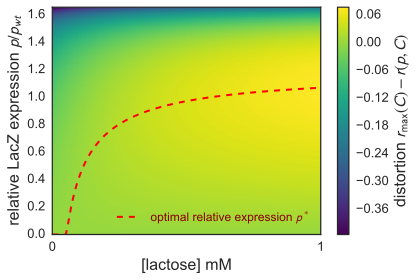

In [136]:
# Define the grid
C_grid = np.linspace(1E-6, 1, 100)
mRNA_grid = np.arange(0, np.floor(param['r_gamma'] * 1.7))
mRNA_grid = np.linspace(0, np.floor(param['r_gamma'] * 1.7), 200)

CC, mm = np.meshgrid(C_grid, mRNA_grid)
growth_diff = abs_growth_rate(CC, mm, **param)

# Redefine the normalized grid. Basically because I am lazy....
mRNA_grid = mRNA_grid / param['r_gamma']

with sns.axes_style('white'):
    fig = plt.figure()
    ax = plt.subplot(111)
    cax = ax.matshow(growth_diff, cmap=cm.viridis,
                    origin='lower', extent=(C_grid.min(), C_grid.max(),
                                            mRNA_grid.min(), mRNA_grid.max()),
                    aspect='auto')#, norm=matplotlib.colors.LogNorm())
    ax.plot(C_grid, evo_utils.p_opt(C_grid), '--',
            label=r'optimal relative expression $p^*$',
            color='red')
    # Format plot
    ax.set_xlim([C_grid.min(), C_grid.max()])
    ax.set_ylim([mRNA_grid.min(), mRNA_grid.max()])
    ax.set_xlabel(r'[lactose] mM')
    ax.set_ylabel(r'relative LacZ expression $p / p_{wt}$')
    # Change default position of axis ticks
    ax.get_xaxis().set_ticks_position('bottom')
    
    leg = ax.legend(loc='lower right', fontsize=12)
    
    # Changing the color of the legend text
    for text in leg.get_texts():
        text.set_color("darkred")

    # Add color-bar
    cbar = fig.colorbar(cax)
    cbar.ax.set_ylabel(r'distortion $r_\max (C) - r(p, C)$')
    
    # Set the ticks in both axis
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end + 0.1, 1))
    
    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(start, end + 0.1, 0.2))
    
    plt.tight_layout()
#     plt.savefig(figdir + 'distortion_function.pdf')

Everything looks fine! Let's apply this cost function to see what we find out.

## Computing the optimal average growth rate $\langle r \rangle _\max$

To obtain what we want we also need to define a function that computes the optimal average growth rate given an input distribution. This is equivalent to the growth rate when there is infinite amount of information and every cell in the distribution is expressing the optimal level.

In other words in our discrete case we will compute

\begin{equation}
    \langle r \rangle _\max = \sum_C P(C) r_\max (C),
\end{equation}

where we wrote it as a sum to emphasize that we are not using Simpson's rule or any other proper numerical integration procedure, but we are actually just performing a simple and plain sum.

In [ ]:
def avg_growth_opt_C(C, PC_fun, delta=0.17, Ks=0.4, eta_o=0.02, M=1.8):
    '''
    Returns the optimal growth rate at concentration C by obtaining the
    optimal expression level as defined in Dekel and Alon's paper and
    evaluating it in the fitness landscape function.
    NOTE:
    Performs the calculation with a simple sum.
    Parameter
    ---------
    C : array-like.
        substrate concentration.
    PC_fun : function.
        function to determine the probability distribution of each of the
        elements of C.
    delta : float.
        growth benefit per substrate cleaved per enzyme.
    Ks : float.
        Monod constant for half maximum growth rate.
    eta_o : float.
        Parameter of the cost function
    M : float.
        Parameter of the cost function

    Returns
    -------
    optimal_growth : array-like
        maximum relative growth rate at concentration(s) C.
    '''
    # obtain the optimal expression level at concnetration(s) C
    mRNA_opt = evo_utils.p_opt(C, delta, Ks, eta_o, M)
    
    # compute the optimal growth rate
    growth_opt = evo_utils.benefit_func(mRNA_opt, C, delta, Ks) - \
                 evo_utils.cost_func(mRNA_opt, eta_o, M)
    
    # compute P(C)
    pC = PC_fun(C) / PC_fun(C).sum()
    
    # return the average optimal growth rate
    return np.sum(pC * growth_opt)

def avg_growth_opt_logC(logC, PC_fun, delta=0.17, Ks=0.4, eta_o=0.02, M=1.8):
    '''
    Returns the optimal growth rate at concentration C by obtaining the
    optimal expression level as defined in Dekel and Alon's paper and
    evaluating it in the fitness landscape function.
    NOTE:
    Performs the calculation with a simple sum.
    Parameter
    ---------
    logC : array-like.
        log substrate concentration.
    PC_fun : function.
        function to determine the probability distribution of each of the
        elements of C.
    delta : float.
        growth benefit per substrate cleaved per enzyme.
    Ks : float.
        Monod constant for half maximum growth rate.
    eta_o : float.
        Parameter of the cost function
    M : float.
        Parameter of the cost function

    Returns
    -------
    optimal_growth : array-like
        maximum relative growth rate at concentration(s) C.
    '''
    # Convert from log to linear scale.
    C = np.power(10, logC)
    
    # obtain the optimal expression level at concnetration(s) C
    mRNA_opt = evo_utils.p_opt(C, delta, Ks, eta_o, M)
    
    # compute the optimal growth rate
    growth_opt = evo_utils.benefit_func(mRNA_opt, C, delta, Ks) - \
                 evo_utils.cost_func(mRNA_opt, eta_o, M)
    
    # compute P(C)
    pC = PC_fun(C) / PC_fun(C).sum()
    
    # return the average optimal growth rate
    return np.sum(pC * growth_opt)

def avg_growth_opt_int_C(C, PC_fun, delta=0.17, Ks=0.4, eta_o=0.02, M=1.8):
    '''
    Returns the optimal growth rate at concentration C by obtaining the
    optimal expression level as defined in Dekel and Alon's paper and
    evaluating it in the fitness landscape function.
    Performs the calculation using the Simpson's integration rule.
    Parameter
    ---------
    C : array-like.
        substrate concentration.
    PC_fun : function.
        function to determine the probability distribution of each of the
        elements of C.
    delta : float.
        growth benefit per substrate cleaved per enzyme.
    Ks : float.
        Monod constant for half maximum growth rate.
    eta_o : float.
        Parameter of the cost function
    M : float.
        Parameter of the cost function

    Returns
    -------
    optimal_growth : array-like
        maximum relative growth rate at concentration(s) C.
    '''
    # obtain the optimal expression level at concnetration(s) C
    mRNA_opt = evo_utils.p_opt(C, delta, Ks, eta_o, M)
    
    # compute the optimal growth rate
    growth_opt = evo_utils.benefit_func(mRNA_opt, C, delta, Ks) - \
                 evo_utils.cost_func(mRNA_opt, eta_o, M)
    
    # compute P(C)
    pC = PC_fun(C)
    
    # return the average optimal growth rate
    return scipy.integrate.simps(pC * growth_opt, x=C)

def avg_growth_opt_int_logC(logC, PC_fun, delta=0.17, Ks=0.4, 
                            eta_o=0.02, M=1.8):
    '''
    Returns the optimal growth rate at concentration C by obtaining the
    optimal expression level as defined in Dekel and Alon's paper and
    evaluating it in the fitness landscape function.
    NOTE:
    Performs the calculation using the Simpson's integration rule.
    Parameter
    ---------
    logC : array-like.
        log substrate concentration.
    PC_fun : function.
        function to determine the probability distribution of each of the
        elements of C.
    delta : float.
        growth benefit per substrate cleaved per enzyme.
    Ks : float.
        Monod constant for half maximum growth rate.
    eta_o : float.
        Parameter of the cost function
    M : float.
        Parameter of the cost function

    Returns
    -------
    optimal_growth : array-like
        maximum relative growth rate at concentration(s) C.
    '''
    # Convert from log to linear scale.
    C = np.power(10, logC)
    
    # obtain the optimal expression level at concnetration(s) C
    mRNA_opt = evo_utils.p_opt(C, delta, Ks, eta_o, M)
    
    # compute the optimal growth rate
    growth_opt = evo_utils.benefit_func(mRNA_opt, C, delta, Ks) - \
                 evo_utils.cost_func(mRNA_opt, eta_o, M)
    
    # compute P(C)
    pC = PC_fun(logC)
    
    # return the average optimal growth rate
    return scipy.integrate.simps(pC * growth_opt, x=logC)

We now have everything ready. Let's get that optimal distribution $P(m \mid C)$!

In [164]:
# Define the parameters for the distortion funciton, a.k.a the growth diff.
param = dict(r_gamma=15.7, delta=0.17, Ks=0.4, eta_o=0.02, M=1.8)

# Define the grid on which integrate
C_grid = np.linspace(1E-4, 5, 101)
# C_grid = -1 / 2 * np.log(np.linspace(1E-3, 1, 101) / 2)
mRNA_grid = np.linspace(0, param['r_gamma'] * 1.7, 100)

# define the values of beta to test
# beta = np.logspace(np.log10(10), np.log10(1000), 20)
beta = np.logspace(np.log10(6 * 10**-2), np.log10(5 * 10**2), 40)

compute_RD = True
if compute_RD:
    # # initialize arrays to save D and RD
    D_array = np.empty_like(beta)
    RD_array = np.empty_like(beta)
    pC_list = list()
    qm_list = list()
    QmC_list = list()
    for i, b in enumerate(beta):
        if i%5 == 0:
            print(i)
        pC, qm, rhoCm, QmC, D, RD = \
        rate_dist(C=C_grid, mRNA=mRNA_grid, beta=b, 
                  PC_fun=evo_utils.PC_expo, fitness_fun=abs_growth_rate, 
                  param=param, epsilon=5E-4, fitness_scale=1)
        D_array[i] = D
        RD_array[i] = RD
        pC_list.append(pC)
        qm_list.append(qm)
        QmC_list.append(QmC)

    # To be consistent and have reproducible results we will save the following:
    # 1. the distortion array
    # 2. the rate-distortion array
    # 3. the concentration probability
    # 4. the mRNA marginal probability
    # 5. the input-output conditional transition matrix
    # 6. the concentration array
    # 7. the mRNA array
    # 8. the parameters used in the distortion function
    output = open(outputdir + 'RD_expo_2_0mM_5mM_test.pkl', 'wb')
    pickle.dump(D_array, output)
    pickle.dump(RD_array, output)
    pickle.dump(pC_list, output)
    pickle.dump(qm_list, output)
    pickle.dump(QmC_list, output)
    pickle.dump(C_grid, output)
    pickle.dump(mRNA_grid, output)
    pickle.dump(param, output)
    output.close()

0
5
10
15
20
25
30
35


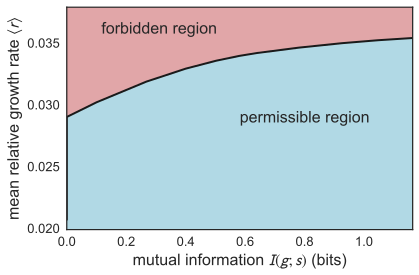

In [168]:
# Load the pickled data
with open(outputdir + 'RD_expo_2_0mM_5mM_test.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    D_array = unpickler.load()
    RD_array = unpickler.load()
    pC_list = unpickler.load()
    param = unpickler.load()

sns.set_color_codes()
with sns.axes_style('white'):
    # plot the limting line
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(RD_array, D_array, 'k')
    
    # show with red the prohibited region
    ax.fill_between(RD_array, D_array, 
                     0.038, 
                     color='r', alpha=0.5)
    ax.text(0.1, 0.9, 'forbidden region', horizontalalignment='left',
             verticalalignment='center',
             transform=ax.transAxes, fontsize=16)
    # show with cyan the allowed region
    ax.fill_between(RD_array, D_array,
                    0.020, 
                     color='c', alpha=0.5)
    ax.text(0.5, 0.5, 'permissible region',
             horizontalalignment='left',
             verticalalignment='center',
             transform=ax.transAxes, fontsize=16)
    
#     # indicate the concentration range used for the calculation
#     ax.text(0.7, 0.05, '[$0$mM, $5$mM]',
#              horizontalalignment='left',
#              verticalalignment='center',
#              transform=ax.transAxes, fontsize=13)
    
    # label axis
    ax.set_ylabel(r'mean relative growth rate $\langle r \rangle$')
    ax.set_xlabel(r'mutual information $I(g;s)$ (bits)')
#     ax.set_title(r'exponential distribution $\tau=2$')
    ax.set_xlim(right=RD_array.max())

    plt.tight_layout()
    plt.savefig(figdir + 'RD_expo_2_0mM_5mM.pdf')

# log uniform distribution

We will begin with the input distribution where the log concentration is uniformly distributed, i.e.

\begin{equation}
    \log C \sim Unif \left[ \log C_{\min} , \log C_{\max} \right].
\end{equation}

### [$10^{-3}$ mM, $1$ mM]

In [ ]:
# Define the parameters for the distortion funciton, a.k.a the growth diff.
param = dict(r_gamma=15.7, delta=0.17, Ks=0.4, eta_o=0.02, M=1.8)

# Define the grid on which integrate
logC_grid = np.linspace(-3, 0, 100)
mRNA_grid = np.arange(0, np.floor(param['r_gamma'] * 1.7))

# define the values of beta to test
beta = np.logspace(np.log10(10), np.log10(1500), 50)
# beta = np.logspace(np.log10(1E-4), np.log10(1E-3), 11)

compute_RD = True
if compute_RD:
    # # initialize arrays to save D and RD
    D_array = np.empty_like(beta)
    RD_array = np.empty_like(beta)
    pC_list = list()
    qm_list = list()
    QmC_list = list()
    for i, b in enumerate(beta):
        if i%5 == 0:
            print(i)
        pC, qm, rhoCm, QmC, D, RD = \
        rate_dist(C=logC_grid, mRNA=mRNA_grid, beta=-b, 
                  PC_fun=evo_utils.PlogC_unif, fitness_fun=growth_diff_logC, 
                  param=param, epsilon=5E-5, fitness_scale=1)
        D_array[i] = D
        RD_array[i] = RD
        pC_list.append(pC)
        qm_list.append(qm)
        QmC_list.append(QmC)

    # To be consistent and have reproducible results we will save the following:
    # 1. the distortion array
    # 2. the rate-distortion array
    # 3. the concentration probability
    # 4. the mRNA marginal probability
    # 5. the input-output conditional transition matrix
    # 6. the concentration array
    # 7. the mRNA array
    # 8. the parameters used in the distortion function
    output = open(outputdir + 'RD_logunif_1E-3mM_1mM.pkl', 'wb')
    pickle.dump(D_array, output)
    pickle.dump(RD_array, output)
    pickle.dump(pC_list, output)
    pickle.dump(qm_list, output)
    pickle.dump(QmC_list, output)
    pickle.dump(logC_grid, output)
    pickle.dump(mRNA_grid, output)
    pickle.dump(param, output)

In [ ]:
# Load the pickled data
pkl_file = open(outputdir + 'RD_logunif_1E-3mM_1mM.pkl', 'rb')
D_array = pickle.load(pkl_file)
RD_array = pickle.load(pkl_file)
pC_list = pickle.load(pkl_file)
pkl_file.close()

# compute the average growth rate given this input distribution
avg_growth_opt = avg_growth_opt_int_logC(logC_grid, evo_utils.PlogC_unif)

sns.set_color_codes()
with sns.axes_style('white'):
    # plot the limting line
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(RD_array, avg_growth_opt - D_array, 'k')
    
    # show with red the prohibited region
    ax.fill_between(RD_array, avg_growth_opt - D_array, 
                     0.012, 
                     color='r', alpha=0.5)
    ax.text(0.1, 0.9, 'forbidden region', horizontalalignment='left',
             verticalalignment='center',
             transform=ax.transAxes, fontsize=16)
    # show with green the allowed region
    ax.fill_between(RD_array, avg_growth_opt - D_array,
                    0.0, 
                     color='c', alpha=0.5)
    ax.text(0.5, 0.5, 'permissible region',
             horizontalalignment='left',
             verticalalignment='center',
             transform=ax.transAxes, fontsize=16)
    
    # indicate the concentration range used for the calculation
    ax.text(0.7, 0.05, '[$10^{-3}$mM, $1$mM]',
             horizontalalignment='left',
             verticalalignment='center',
             transform=ax.transAxes, fontsize=13)
    
    # label axis
    ax.set_ylabel(r'mean relative growth rate $\langle r \rangle$')
    ax.set_xlabel(r'mutual information [bits]')
    ax.set_title('log uniform distribution')
    ax.set_xlim(right=RD_array.max())

    plt.savefig(figdir + 'RD_logunif_1E-3mM_1mM.pdf')

### [$10^{-6}$ mM, $5$ mM]

In [ ]:
# Define the parameters for the distortion funciton, a.k.a the growth diff.
param = dict(r_gamma=15.7, delta=0.17, Ks=0.4, eta_o=0.02, M=1.8)

# Define the grid on which integrate
logC_grid = np.linspace(-6, np.log10(5), 100)
mRNA_grid = np.linspace(0, param['r_gamma'] * 1.7, 100)

# define the values of beta to test
beta = np.logspace(np.log10(10), np.log10(1500), 50)

compute_RD = True
if compute_RD:
    # # initialize arrays to save D and RD
    D_array = np.empty_like(beta)
    RD_array = np.empty_like(beta)
    pC_list = list()
    qm_list = list()
    QmC_list = list()
    for i, b in enumerate(beta):
        if i%5 == 0:
            print(i)
        pC, qm, rhoCm, QmC, D, RD = \
        rate_dist(C=logC_grid, mRNA=mRNA_grid, beta=-b, 
                  PC_fun=evo_utils.PlogC_unif, fitness_fun=growth_diff_logC, 
                  param=param, epsilon=5E-5, fitness_scale=1)
        D_array[i] = D
        RD_array[i] = RD
        pC_list.append(pC)
        qm_list.append(qm)
        QmC_list.append(QmC)

    # To be consistent and have reproducible results we will save the following:
    # 1. the distortion array
    # 2. the rate-distortion array
    # 3. the concentration probability
    # 4. the mRNA marginal probability
    # 5. the input-output conditional transition matrix
    # 6. the concentration array
    # 7. the mRNA array
    # 8. the parameters used in the distortion function
    output = open(outputdir + 'RD_logunif_1E-6mM_5mM.pkl', 'wb')
    pickle.dump(D_array, output)
    pickle.dump(RD_array, output)
    pickle.dump(pC_list, output)
    pickle.dump(qm_list, output)
    pickle.dump(QmC_list, output)
    pickle.dump(logC_grid, output)
    pickle.dump(mRNA_grid, output)
    pickle.dump(param, output)

In [ ]:
# Load the pickled data
with open(outputdir + 'RD_logunif_1E-6mM_5mM.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    D_array = unpickler.load()
    RD_array = unpickler.load()
    pC_list = unpickler.load()
    param = unpickler.load()

# compute the average growth rate given this input distribution
avg_growth_opt = avg_growth_opt_int_logC(logC_grid, evo_utils.PlogC_unif)

sns.set_color_codes()
with sns.axes_style('white'):
    # plot the limting line
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(RD_array, avg_growth_opt - D_array, 'k')
    
    # show with red the prohibited region
    ax.fill_between(RD_array, avg_growth_opt - D_array, 
                     0.018, 
                     color='r', alpha=0.5)
    ax.text(0.1, 0.9, 'forbidden region', horizontalalignment='left',
             verticalalignment='center',
             transform=ax.transAxes, fontsize=16)
    # show with green the allowed region
    ax.fill_between(RD_array, avg_growth_opt - D_array,
                    0.0, 
                     color='c', alpha=0.5)
    ax.text(0.5, 0.5, 'permissible region',
             horizontalalignment='left',
             verticalalignment='center',
             transform=ax.transAxes, fontsize=16)
    
    # indicate the concentration range used for the calculation
    ax.text(0.7, 0.05, '[$10^{-6}$mM, $5$mM]',
             horizontalalignment='left',
             verticalalignment='center',
             transform=ax.transAxes, fontsize=13)
    
    # label axis
    ax.set_ylabel(r'mean relative growth rate $\langle r \rangle$')
    ax.set_xlabel(r'mutual information [bits]')
    ax.set_title('log uniform distribution')
    ax.set_xlim(right=RD_array.max())

    plt.savefig(figdir + 'RD_logunif_1E-6mM_5mM.pdf')

## Assuming a different distribution for the substrate.

Now let's try using the same distribution that Bialek uses in his paper, i.e.
\begin{equation}
    P(C) \propto \exp(- 2 C).
\end{equation}

### $C \sim Expo(\tau=2)$ [$0$ mM, $5$ mM]

In [ ]:
# Define the parameters for the distortion funciton, a.k.a the growth diff.
param = dict(r_gamma=15.7, delta=0.17, Ks=0.4, eta_o=0.02, M=1.8)

# Define the grid on which integrate
C_grid = np.linspace(0, 5, 100)
mRNA_grid = np.linspace(0, param['r_gamma'] * 1.7, 100)

# define the values of beta to test
# beta = np.logspace(np.log10(10), np.log10(1500), 50)
beta = np.logspace(np.log10(1000), np.log10(100000), 10)

compute_RD = True
if compute_RD:
    # # initialize arrays to save D and RD
    D_array = np.empty_like(beta)
    RD_array = np.empty_like(beta)
    pC_list = list()
    qm_list = list()
    QmC_list = list()
    for i, b in enumerate(beta):
        if i%5 == 0:
            print(i)
        pC, qm, rhoCm, QmC, D, RD = \
        rate_dist(C=C_grid, mRNA=mRNA_grid, beta=-b, 
                  PC_fun=evo_utils.PC_expo, fitness_fun=growth_diff_C, 
                  param=param, epsilon=5E-5, fitness_scale=1)
        D_array[i] = D
        RD_array[i] = RD
        pC_list.append(pC)
        qm_list.append(qm)
        QmC_list.append(QmC)

    # To be consistent and have reproducible results we will save the following:
    # 1. the distortion array
    # 2. the rate-distortion array
    # 3. the concentration probability
    # 4. the mRNA marginal probability
    # 5. the input-output conditional transition matrix
    # 6. the concentration array
    # 7. the mRNA array
    # 8. the parameters used in the distortion function
    output = open(outputdir + 'RD_expo_2_0mM_5mM_test.pkl', 'wb')
    pickle.dump(D_array, output)
    pickle.dump(RD_array, output)
    pickle.dump(pC_list, output)
    pickle.dump(qm_list, output)
    pickle.dump(QmC_list, output)
    pickle.dump(C_grid, output)
    pickle.dump(mRNA_grid, output)
    pickle.dump(param, output)
    output.close()

In [ ]:
# Load the pickled data
with open(outputdir + 'RD_expo_2_0mM_5mM_test.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    D_array = unpickler.load()
    RD_array = unpickler.load()
    pC_list = unpickler.load()
    param = unpickler.load()

# compute the average growth rate given this input distribution
avg_growth_opt = avg_growth_opt_int_C(C_grid, evo_utils.PC_expo)

sns.set_color_codes()
with sns.axes_style('white'):
    # plot the limting line
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(RD_array, avg_growth_opt - D_array, 'k')
    
#     # show with red the prohibited region
#     ax.fill_between(RD_array, avg_growth_opt - D_array, 
#                      0.038, 
#                      color='r', alpha=0.5)
#     ax.text(0.1, 0.9, 'forbidden region', horizontalalignment='left',
#              verticalalignment='center',
#              transform=ax.transAxes, fontsize=16)
#     # show with cyan the allowed region
#     ax.fill_between(RD_array, avg_growth_opt - D_array,
#                     0.029, 
#                      color='c', alpha=0.5)
#     ax.text(0.5, 0.5, 'permissible region',
#              horizontalalignment='left',
#              verticalalignment='center',
#              transform=ax.transAxes, fontsize=16)
    
#     # indicate the concentration range used for the calculation
#     ax.text(0.7, 0.05, '[$0$mM, $5$mM]',
#              horizontalalignment='left',
#              verticalalignment='center',
#              transform=ax.transAxes, fontsize=13)
    
    # label axis
    ax.set_ylabel(r'mean relative growth rate $\langle r \rangle$')
    ax.set_xlabel(r'mutual information $I(g;s)$ (bits)')
#     ax.set_title(r'exponential distribution $\tau=2$')
    ax.set_xlim(right=RD_array.max())

    plt.tight_layout()
#     plt.savefig(figdir + 'RD_expo_2_0mM_5mM.pdf')

In [ ]:
# Load the pickled data
with open(outputdir + 'RD_expo_2_0mM_5mM.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    D_array = unpickler.load()
    RD_array = unpickler.load()
    pC_list = unpickler.load()
    qm_list = unpickler.load()
    QmC_list = unpickler.load()
    C_grid = unpickler.load()
    mRNA_grid = unpickler.load()
    param = unpickler.load()

# compute the average growth rate given this input distribution
avg_growth_opt = avg_growth_opt_int_C(C_grid, evo_utils.PC_expo)

sns.set_color_codes()
with sns.axes_style('white'):
    # plot the limting line
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(RD_array, avg_growth_opt - D_array, 'k')
    
    # show with red the prohibited region
    ax.fill_between(RD_array, avg_growth_opt - D_array, 
                     0.045, 
                     color='r', alpha=0.5)
    ax.text(0.1, 0.9, 'forbidden region', horizontalalignment='left',
             verticalalignment='center',
             transform=ax.transAxes, fontsize=16)
    # show with green the allowed region
    ax.fill_between(RD_array, avg_growth_opt - D_array,
                    0.0, 
                     color='c', alpha=0.5)
    ax.text(0.5, 0.5, 'permissible region',
             horizontalalignment='left',
             verticalalignment='center',
             transform=ax.transAxes, fontsize=16)
    
    # indicate the concentration range used for the calculation
    ax.text(0.7, 0.05, '[$0$mM, $5$mM]',
             horizontalalignment='left',
             verticalalignment='center',
             transform=ax.transAxes, fontsize=13)
    
    # label axis
    ax.set_ylabel(r'mean relative growth rate $\langle r \rangle$')
    ax.set_xlabel(r'mutual information [bits]')
    ax.set_title(r'exponential distribution $\tau=2$')
    ax.set_xlim(right=RD_array.max())

    plt.savefig(figdir + 'RD_expo_2_0mM_5mM_zero_intercept.pdf')

### $C \sim Expo(\tau=10)$ [$0$ mM, $5$ mM]

In [ ]:
# Define the parameters for the distortion funciton, a.k.a the growth diff.
param = dict(r_gamma=15.7, delta=0.17, Ks=0.4, eta_o=0.02, M=1.8)

# Define the grid on which integrate
C_grid = np.linspace(0, 5, 100)
mRNA_grid = np.linspace(0, param['r_gamma'] * 1.7, 100)

# Define a lambda function to change the parameter tau and still be able to
# feed the PC_fun to the Blahut algorithm
PC_tau10 = lambda C: evo_utils.PC_expo(C, 10)

# define the values of beta to test
beta = np.logspace(np.log10(10), np.log10(1500), 50)

compute_RD = True
if compute_RD:
    # # initialize arrays to save D and RD
    D_array = np.empty_like(beta)
    RD_array = np.empty_like(beta)
    pC_list = list()
    qm_list = list()
    QmC_list = list()
    for i, b in enumerate(beta):
        if i%5 == 0:
            print(i)
        pC, qm, rhoCm, QmC, D, RD = \
        rate_dist(C=C_grid, mRNA=mRNA_grid, beta=-b, 
                  PC_fun=PC_tau10, fitness_fun=growth_diff_C, 
                  param=param, epsilon=5E-5, fitness_scale=1)
        D_array[i] = D
        RD_array[i] = RD
        pC_list.append(pC)
        qm_list.append(qm)
        QmC_list.append(QmC)

    # To be consistent and have reproducible results we will save the following:
    # 1. the distortion array
    # 2. the rate-distortion array
    # 3. the concentration probability
    # 4. the mRNA marginal probability
    # 5. the input-output conditional transition matrix
    # 6. the concentration array
    # 7. the mRNA array
    # 8. the parameters used in the distortion function
    output = open(outputdir + 'RD_expo_10_0mM_5mM.pkl', 'wb')
    pickle.dump(D_array, output)
    pickle.dump(RD_array, output)
    pickle.dump(pC_list, output)
    pickle.dump(qm_list, output)
    pickle.dump(QmC_list, output)
    pickle.dump(C_grid, output)
    pickle.dump(mRNA_grid, output)
    pickle.dump(param, output)
    output.close()

In [ ]:
# Load the pickled data
with open(outputdir + 'RD_expo_10_0mM_5mM.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    D_array = unpickler.load()
    RD_array = unpickler.load()
    pC_list = unpickler.load()
    qm_list = unpickler.load()
    QmC_list = unpickler.load()
    C_grid = unpickler.load()
    mRNA_grid = unpickler.load()
    param = unpickler.load()

# Define a lambda function to change the parameter tau and still be able to
# feed the PC_fun to the Blahut algorithm
PC_tau10 = lambda C: evo_utils.PC_expo(C, 10)

# compute the average growth rate given this input distribution
avg_growth_opt = avg_growth_opt_int_C(C_grid, PC_tau10)

sns.set_color_codes()
with sns.axes_style('white'):
    # plot the limting line
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(RD_array, avg_growth_opt - D_array, 'k')
    
    # show with red the prohibited region
    ax.fill_between(RD_array, avg_growth_opt - D_array, 
                     0.007, 
                     color='r', alpha=0.5)
    ax.text(0.1, 0.9, 'forbidden region', horizontalalignment='left',
             verticalalignment='center',
             transform=ax.transAxes, fontsize=16)
    # show with green the allowed region
    ax.fill_between(RD_array, avg_growth_opt - D_array,
                    0.001, 
                     color='c', alpha=0.5)
    ax.text(0.5, 0.5, 'permissible region',
             horizontalalignment='left',
             verticalalignment='center',
             transform=ax.transAxes, fontsize=16)
    
    # indicate the concentration range used for the calculation
    ax.text(0.7, 0.05, '[$0$mM, $5$mM]',
             horizontalalignment='left',
             verticalalignment='center',
             transform=ax.transAxes, fontsize=13)
    
    # label axis
    ax.set_ylabel(r'mean relative growth rate $\langle r \rangle$')
    ax.set_xlabel(r'mutual information [bits]')
    ax.set_title(r'exponential distribution $\tau=10$')
    ax.set_xlim(right=RD_array.max())

    plt.savefig(figdir + 'RD_expo_10_0mM_5mM.pdf')

## Cranking up the selection.

It will be interesting to modify the fitness landscape parameters in order to make the selection much stronger such that the vertical axis of the information/fitness plane increases significantly. Let's see how we could play with these parameters

In [ ]:
# param = dict(r_gamma=15.7, delta=0.17, Ks=0.4, eta_o=0.02, M=1.8)
param = dict(r_gamma=15.7, delta=1.7, Ks=0.4, eta_o=0.2, M=3)

# Define the grid on which integrate
C_grid = np.linspace(1E-4, 1, 100)
mRNA_grid = np.linspace(0, 15.7 * 1.5, 101)

CC, mm = np.meshgrid(C_grid, mRNA_grid)
growth_diff = growth_diff_C(CC, mm, **param)

# Redefine the normalized grid. Basically because I am lazy....
mRNA_grid = np.linspace(0, 15.7 * 1.5, 101) / param['r_gamma']

with sns.axes_style('white'):
    fig = plt.figure()
    ax = plt.subplot(111)
    cax = ax.matshow(growth_diff, cmap=cm.viridis_r,
                    origin='lower', extent=(C_grid.min(), C_grid.max(),
                                            mRNA_grid.min(), mRNA_grid.max()),
                    aspect='auto')
    ax.plot(C_grid, evo_utils.p_opt(C_grid),
            label=r'optimal relative expression $p^*$',
            color='darkred')
    # Format plot
    ax.set_xlim([C_grid.min(), C_grid.max()])
    ax.set_ylim([mRNA_grid.min(), mRNA_grid.max()])
    ax.set_xlabel(r'[lactose] mM')
    ax.set_ylabel(r'relative LacZ expression $p / p_{wt}$')
    # Change default position of axis ticks
    ax.get_xaxis().set_ticks_position('bottom')
    
    leg = ax.legend(loc='lower right', fontsize=12)
    # Changing the color of the legend text
    for text in leg.get_texts():
        text.set_color("white")

    # Add color-bar
    cbar = fig.colorbar(cax)
    cbar.ax.set_ylabel(r'$r_\max (C) - r(p, C)$')
    
    plt.tight_layout()

This seems like a good set of parameters, let's see if the Blahut algorithm can converge given this scenario.

In [ ]:
# Define the grid on which integrate
C_grid = np.linspace(1E-8, 1, 100)
mRNA_grid = np.linspace(0, param['r_gamma'] * 1.5, 101)

# define the values of beta to test
beta = np.logspace(np.log10(1), np.log10(1000), 50)

compute_RD = True
if compute_RD:
    # # initialize arrays to save D and RD
    D_array = np.empty_like(beta)
    RD_array = np.empty_like(beta)
    pC_list = list()
    qm_list = list()
    QmC_list = list()
    for i, b in enumerate(beta):
        if i%5 == 0:
            print(i)
        pC, qm, rhoCm, QmC, D, RD = \
        rate_dist(C=C_grid, mRNA=mRNA_grid, beta=-b, 
                  PC_fun=evo_utils.PC_expo, fitness_fun=growth_diff_C, 
                  param=param, epsilon=5E-5, fitness_scale=1)
        D_array[i] = D
        RD_array[i] = RD
        pC_list.append(pC)
        qm_list.append(qm)
        QmC_list.append(QmC)

    # save output with pickle
    # open / create a .pkl file
    output = open(tmpdir + 'RD_expo_C_high_selection.pkl', 'wb')
    pickle.dump(D_array, output)
    pickle.dump(RD_array, output)
    pickle.dump(pC_list, output)
    pickle.dump(qm_list, output)
    pickle.dump(QmC_list, output)

# Load the pickled data
pkl_file = open(tmpdir + 'RD_expo_C_high_selection.pkl', 'rb')
D_array = pickle.load(pkl_file)
RD_array = pickle.load(pkl_file)
pC_list = pickle.load(pkl_file)
qm_list = pickle.load(pkl_file)
QmC_list = pickle.load(pkl_file)

param_opt = param.copy()
del param_opt['r_gamma']
# compute the average growth rate given this input distribution
avg_growth_opt = avg_growth_opt_C(C_grid, evo_utils.PC_expo, **param_opt)

In [ ]:
sns.set_color_codes()
with sns.axes_style('white'):
    # plot the limting line
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(RD_array, avg_growth_opt - D_array, 'k')
    
    # show with red the prohibited region
    ax.fill_between(RD_array, avg_growth_opt - D_array, 
                     0.5, 
                     color='r', alpha=0.5)
    ax.text(0.1, 0.9, 'forbidden region', horizontalalignment='left',
             verticalalignment='center',
             transform=ax.transAxes, fontsize=16)
    # show with green the allowed region
    ax.fill_between(RD_array, avg_growth_opt - D_array,
                    0.4, 
                     color='c', alpha=0.5)
    ax.text(0.5, 0.5, 'permissible region',
             horizontalalignment='left',
             verticalalignment='center',
             transform=ax.transAxes, fontsize=16)
    
    # label axis
    ax.set_ylabel(r'mean relative growth rate $\langle r \rangle$')
    ax.set_xlabel(r'mutual information [bits]')
    ax.set_title('exponential distribution')
    ax.set_xlim(right=RD_array.max())
    plt.savefig(outputdir + 'fitness_information_expo_high_selection.pdf')